<a href="https://colab.research.google.com/github/PradyumnaGupta/rainnet/blob/master/RainNet_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adaptée par KHADRAOUI M.El Bachir pour le TER sur Rainnet

# RainNet Training Notebook

Author:[Pradyumna Gupta](https://github.com/PradyumnaGupta)

This notebook is created and executed on Google Colaboratory with Google Drive Mounted.

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


* Mounting Google Drive



In [2]:
from google.colab import drive
drive.mount('/content/drive') #Dans lequel est contenu l'HDF5 des images Ozone

Mounted at /content/drive


* Importing libraries

In [3]:
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split
import os

import matplotlib.pyplot as plt 
import imageio
import PIL
from PIL import ImageFile
import cv2
import numpy as np
from IPython.display import display
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler

import torch
import torch.nn as nn
from torch.nn import functional as F
# import pretrainedmodels
import torch.optim as optim
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score
import math
import time
import albumentations
import random
from tqdm import tqdm
import tensorflow as tf

ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

* Defining some data preparing and preprocessing functions

In [4]:
def Scaler(array):
    return np.log(array+0.01)


def invScaler(array):
    return np.exp(array) - 0.01

#NO PADDING TO DO
def pad_to_shape(array, from_shape=128, to_shape=128, how="mirror"):
    # calculate how much to pad in respect with native resolution
    padding = int( (to_shape - from_shape) / 2)
    # for input shape as (batch, W, H, channels)
    if how == "zero":
        array_padded = np.pad(array, ((0,0),(padding,padding),(padding,padding),(0,0)), mode="constant", constant_values=0)
    elif how == "mirror":
        array_padded = np.pad(array, ((0,0),(padding,padding),(padding,padding),(0,0)), mode="reflect")
    return array_padded

#No processing to do -> Keeping it 128
def pred_to_rad(pred, from_shape=128, to_shape=128):
    # pred shape 12,928,928
    padding = int( (from_shape - to_shape) / 2)
    return pred[::, padding:padding+to_shape, padding:padding+to_shape].copy()


def data_preprocessing(X):
    
    # 0. Right shape for batch
    X = np.moveaxis(X, 0, -1)
    X = X[np.newaxis, ::, ::, ::]
    # 1. To log scale
    X = Scaler(X)
    # 2. from 900x900 to 928x928
    X = pad_to_shape(X)
    
    return X


def data_postprocessing(nwcst):

    # 0. Squeeze empty dimensions
    nwcst = np.squeeze(np.array(nwcst))
    # 1. Convert back to rainfall depth
    nwcst = invScaler(nwcst)
    # 2. Convert from 928x928 back to 900x900
    nwcst = pred_to_rad(nwcst)
    # 3. Return only positive values
    nwcst = np.where(nwcst>0, nwcst, 0)
    return nwcst

* Constructing Dataloaders

Dans le répértoire d'origine i+3 est supposée être à la place de i+4, cependant, l'auteur a précisé dans la section issues du répertoire Github qu'il s'agissait d'une erreur à corriger : https://github.com/hydrogo/rainnet/issues/9
Cela a été corrigé.

In [5]:
class Dataset(tf.keras.utils.Sequence):
    
    def __init__(
            self, 
            dataset_dict,
            image_names,
            batch_size
    ):
        self.keys = image_names
        self.dataset = dataset_dict
        self.bs = batch_size
    #A ce niveau, 4 images de t, t-6, t-12, t-18 sont saisies et mises dans un array avant de subir le preprocessing
    def get_index(self,i):
      x = []
      for j in range(4): #last four six hours
        try:
          arr = np.array(self.dataset.get(self.keys[i+j]))
        except:
          print(i,j)
        x.append(arr)
      
      x = data_preprocessing(np.stack(x,0))
      # x = np.transpose(np.squeeze(x),(2,0,1)) 
      x = np.squeeze(x)
      y = np.squeeze(data_preprocessing(np.array(self.dataset[self.keys[i+4]])[np.newaxis,:,:])) #Récupérer celui qui devrait être prédit i + 4
      #Dans le répértoire d'origine i+3 est supposée être à la place de i+4, cependant, l'auteur a précisé dans la section issues du répertoire Github qu'il s'agissait d'une erreur
      #à corriger : https://github.com/hydrogo/rainnet/issues/9
      #Je l'ai corrigée ici
      return x.astype('float32'),y.astype('float32') #Etonnant, j'ai du convertir en Float16
    
    def __getitem__(self, index):
        
      X = []
      Y = []

      for i in range(index*self.bs,(index+1)*self.bs):
        x,y = self.get_index(i)
        X.append(x[np.newaxis,:])
        Y.append(y[np.newaxis,:])

      return X,Y
        
    def __len__(self):
      return (len(self.keys) - 4)//self.bs

* Loading the dataset dictionary.

The dataset consists of a large dictionary where the keys are the image names and the value is the actual image in the form of a numpy array.The dataset can be downloaded from [here](https://drive.google.com/file/d/1eLX5wGUgzpSuDn7d_HuV117sOyChDsHw/view?usp=sharing). (MIS A JOUR)

In [6]:
import h5py
dataset_dict = h5py.File('drive/MyDrive/OzoneData/Ozone.hdf5', 'r')

* Loading the image names.

The image names are present in the keys txt file which can be downloaded from [here](https://drive.google.com/file/d/1NnQExKFF-ndiGvsK_AxIqbtNZSHE97Eo/view?usp=sharing). (MIS A JOUR)

The data from the year 2010-2016 will be used for training purposes, the data from the year 2018 will be used for validation purposes and the data from 2019 for verification.

In [7]:
import ast
with open('drive/MyDrive/OzoneData/Ozone_keys.txt','r') as f:
  image_names = ast.literal_eval(f.read())
image_names = [name for name in image_names if name[:4]>'2010']

train_images = [name for name in tqdm(image_names) if "2019" not in name] #2010-2018
val_images = [name for name in tqdm(image_names) if name[0:4]=="2019"] #2018-2019

100%|██████████| 13148/13148 [00:00<00:00, 704210.31it/s]


* Instantiating the dataloaders.

In [8]:
train_dataset = Dataset(
    dataset_dict=dataset_dict,
    image_names=train_images,
    batch_size=1
)

valid_dataset = Dataset(
    dataset_dict=dataset_dict,
    image_names=val_images,
    batch_size=1
)

* Constructing the RainNet model.

In [9]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

def rainnet(input_shape=(128, 128, 4), mode="regression"):

    """
    The function for building the RainNet (v1.0) model from scratch
    using Keras functional API.
    Parameters:
    input size: tuple(W x H x C), where W (width) and H (height)
    describe spatial dimensions of input data (e.g., 928x928 for RY data);
    and C (channels) describes temporal (depth) dimension of 
    input data (e.g., 4 means accounting four latest radar scans at time
    t-15, t-10, t-5 minutes, and t)
    
    mode: "regression" (default) or "segmentation". 
    For "regression" mode the last activation function is linear, 
    while for "segmentation" it is sigmoid.
    To train RainNet to predict continuous precipitation intensities use 
    "regression" mode. 
    RainNet could be trained to predict the exceedance of specific intensity 
    thresholds. For that purpose, use "segmentation" mode.
    """

    #IN THIS CASE IT'S t-18, t-12, t-6, and t

    inputs = Input(input_shape)

    conv1f = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(inputs)
    conv1f = Activation("relu")(conv1f)
    conv1s = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(conv1f)
    conv1s = Activation("relu")(conv1s)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1s)

    conv2f = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(pool1)
    conv2f = Activation("relu")(conv2f)
    conv2s = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(conv2f)
    conv2s = Activation("relu")(conv2s)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2s)

    conv3f = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(pool2)
    conv3f = Activation("relu")(conv3f)
    conv3s = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(conv3f)
    conv3s = Activation("relu")(conv3s)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3s)

    conv4f = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(pool3)
    conv4f = Activation("relu")(conv4f)
    conv4s = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(conv4f)
    conv4s = Activation("relu")(conv4s)
    drop4 = Dropout(0.5)(conv4s)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5f = Conv2D(1024, 3, padding='same', kernel_initializer='he_normal')(pool4)
    conv5f = Activation("relu")(conv5f)
    conv5s = Conv2D(1024, 3, padding='same', kernel_initializer='he_normal')(conv5f)
    conv5s = Activation("relu")(conv5s)
    drop5 = Dropout(0.5)(conv5s)

    up6 = concatenate([UpSampling2D(size=(2, 2))(drop5), conv4s], axis=3)
    conv6 = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Activation("relu")(conv6)
    conv6 = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = Activation("relu")(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3s], axis=3)
    conv7 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Activation("relu")(conv7)
    conv7 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = Activation("relu")(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2s], axis=3)
    conv8 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Activation("relu")(conv8)
    conv8 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = Activation("relu")(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1s], axis=3)
    conv9 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Activation("relu")(conv9)
    conv9 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Activation("relu")(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    if mode == "regression":
        outputs = Conv2D(1, 1, activation='linear')(conv9)
    elif mode == "segmentation":
        outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

* Instantiating and compiling the model with Adam optimizer and Log_Cosh loss function.


In [10]:
model = rainnet()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-4),loss='log_cosh')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


* Start Training

In [11]:
model.fit(x=train_dataset,validation_data=valid_dataset,epochs=2)

Epoch 1/2
11684/11684 [==============================] - 1456s 123ms/step - loss: 0.0098 - val_loss: 0.0011
Epoch 2/2
11684/11684 [==============================] - 1437s 123ms/step - loss: 0.0018 - val_loss: 0.0013


In [14]:
#ENREGISTRER LE MODELE

model.save('Ozone_model_powered_by_Rainnet_v2e.h5')

In [13]:
#Donner t-18,t-12,t-16,t pour avoir t+6 et plus

In [22]:
#POUR PREDICTION
data = np.loadtxt('text.txt') #t-18 : 2019113000
data2 = np.loadtxt('text2.txt') #t-12 : 2019113006
data3 = np.loadtxt('text3.txt') #t-6 : 2019113012
data4 = np.loadtxt('text4.txt') #t : 2019113018
#POUR EVALUATION
data5 = np.loadtxt('text5.txt') 
data6 = np.loadtxt('text6.txt')
data7 = np.loadtxt('text7.txt')
data8 = np.loadtxt('text8.txt')


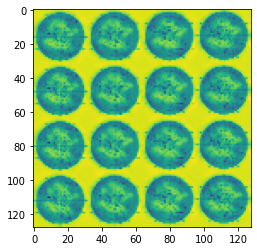

In [26]:
full = np.zeros((4,1,128,128))
full[0] = data #t-18 : 2019113000
full[1] = data2 #t-12 : 2019113006
full[2] = data3 #t-6 : 2019113012
full[3] = data4 #t : 2019113018
full = full.reshape(1,128,128,4)
prediction = model.predict(full) #It contains prediction for t+6 t+12 t+18 t+24
prediction_reshaped = prediction.reshape(128,128)
plt.imshow(prediction_reshaped)
plt.show()

In [33]:
full2 = np.zeros((4,1,128,128))
full2[0] = data5 #t+6 : 2019120100
full2[1] = data6 #t+12 : 2019120106
full2[2] = data7 #t+16 : 2019120112
full2[3] = data8 #t+18 : 2019120118

In [34]:
full2 = full2.reshape(1,128,128,4)
model.evaluate(full, full2)


1/1 [==============================] - 0s 78ms/step - loss: 15.6268


15.62678337097168